#**PREDIKSI HARGA PERAK MENGGUNAKAN METODE LSTM(LONG SHORT-TERM MEMORY)**

##Latar Belakang

perak meupakan salah satu komoditas berharga yang memiliki peran penting dalam berbagai sektor,
seperti industri,perhiasan,dan investasi. pergerakan harga perak dipengaruhi oleh berbagai faktor,seperti permintaan dan penawaran global,
kondisi ekonomi,nilai tukar uang,hingga pergerakan harga komoditas lain.dengan pentingnya perak dalam
perekonomian global,prediksi harga perak menjadi kebutuhan yang penting bagi pelaku pasar,investor,dan pembuat kebijakan untuk mengurangi
risiko dan mengambil keputusan yang tepat.

Dengan kemajuan jaman digitalisasi dan penggunaan pembelajaran mesin(machine learning) menjadi solusi untuk memahami pola dan tren dalam riwayat data harga perak.salah satu metode machine learning yang sering digunakan untuk analisi data time series adalah Long Short-Term Memory(LSTM),metode pengembangan dari jaringan saraf tiruan (RNN).LSTM digunakan untuk menangkap memory jangka panjang dalam data time series ,sehingga sangat cocok digunakan untuk memodelkan pola yang kompleks dalam data time series harga perak.




##Tujuan

projek ini bertujuan untuk merancang dan mengimplementasikan model prediksi harga perak dengan metode LSTM,dan menganalisis performa model.

##Rumusan Masalah

1.bagaimana merancang model prediksi harga perak menggunakan metode Long Short-Term Memory dengan data time series?

2.bagaimana proses memahami hasil prediksi harga perak yang dihasilkan oleh model LSTM untuk membantu mengambil keputusan dalam bidang investasi dan perdagangan komoditas.

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gdown
from sklearn.preprocessing import MinMaxScaler

In [29]:
# Download CSV file
url = 'https://drive.google.com/uc?id=1c9QkcnFTeLvhR5SqMZeczS6CVDYB3GGz'
output = 'Data Historis Perak Berjangka.csv'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1c9QkcnFTeLvhR5SqMZeczS6CVDYB3GGz
To: /content/Data Historis Perak Berjangka.csv
100%|██████████| 81.9k/81.9k [00:00<00:00, 17.1MB/s]


'Data Historis Perak Berjangka.csv'

In [30]:
# Load the data
df_asli = pd.read_csv('Data Historis Perak Berjangka.csv')

df_asli.head()

,Tanggal,Terakhir,Pembukaan,Tertinggi,Terendah,Vol.,Perubahan%
0,11/10/2024,"31,747","31,380","31,802","31,260",NaN,"1,62%"
1,10/10/2024,"31,240","30,710","31,400","30,570",NaN,"1,86%"
2,09/10/2024,"30,670","30,860","31,005","30,435","52,15K","0,23%"
3,08/10/2024,"30,600","31,945","32,020","30,345","96,75K","-4,39%"
4,07/10/2024,"32,004","32,450","32,595","31,655","55,63K","-1,20%"


In [31]:
print(df_asli.columns)
num_rows = df_asli.shape[0]
print(f"Jumlah baris dalam dataframe: {num_rows}")

Index(['Tanggal', 'Terakhir', 'Pembukaan', 'Tertinggi', 'Terendah', 'Vol.',
       'Perubahan%'],
      dtype='object')
Jumlah baris dalam dataframe: 1243


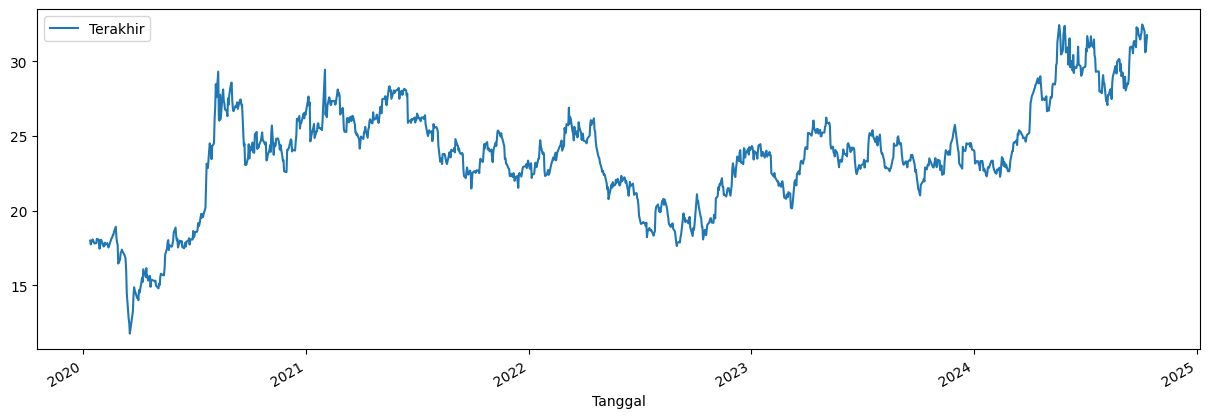

In [32]:
#Plotting data
df_asli['Tanggal'] = pd.to_datetime(df_asli['Tanggal'], dayfirst=True, format='%d/%m/%Y')
df_asli.set_index('Tanggal', inplace=True)
df_asli['Terakhir'] = df_asli['Terakhir'].astype(str).str.replace(',', '.', regex=False).astype(float)
df_asli.plot(figsize=(15, 5))
plt.show()

In [33]:
# Check data hilang
print(f"Jumlah data yang hilang: {df_asli['Terakhir'].isnull().sum()}")
# Handle missing values (e.g., forward fill)
#df_asli['Terakhir'].fillna(method='ffill', inplace=True)

Jumlah data yang hilang: 0


In [34]:
# Normalisasi
scaler = MinMaxScaler()
df_asli['Terakhir_Normalized'] = scaler.fit_transform(df_asli[['Terakhir']])
df_asli.head()


,Terakhir,Pembukaan,Tertinggi,Terendah,Vol.,Perubahan%,Terakhir_Normalized
Tanggal,,,,,,,
2024-10-11,31.747,"31,380","31,802","31,260",NaN,"1,62%",0.965349
2024-10-10,31.240,"30,710","31,400","30,570",NaN,"1,86%",0.940847
2024-10-09,30.670,"30,860","31,005","30,435","52,15K","0,23%",0.913300
2024-10-08,30.600,"31,945","32,020","30,345","96,75K","-4,39%",0.909917
2024-10-07,32.004,"32,450","32,595","31,655","55,63K","-1,20%",0.977769


In [35]:
#import joblib

# Contoh scaler yang telah digunakan
#scaler = MinMaxScaler()

# Menyimpan scaler ke file
#joblib.dump(scaler, 'minmax_scaler.pkl')
#print("Scaler telah disimpan ke file 'minmax_scaler.pkl'")


In [36]:
terakhir = df_asli[['Terakhir']]
terakhir.head()

,Terakhir
Tanggal,
2024-10-11,31.747
2024-10-10,31.240
2024-10-09,30.670
2024-10-08,30.600
2024-10-07,32.004


In [37]:
terakhir_normalized = df_asli[['Terakhir_Normalized']]
terakhir_normalized.head()

,Terakhir_Normalized
Tanggal,
2024-10-11,0.965349
2024-10-10,0.940847
2024-10-09,0.913300
2024-10-08,0.909917
2024-10-07,0.977769


In [38]:
# membuat sliding window
def sliding_window_embedded(data, lags, target_column='Terakhir_Normalized'):
    result = pd.DataFrame(data[target_column])
    for lag in lags:
        result[f't-{lag}'] = data[target_column].shift(lag)

    df_windowed = pd.concat([data, result.iloc[:, 1:]], axis=1)  # Concatenate with original DataFrame
    df_windowed.dropna(inplace=True)

    return df_windowed

In [39]:
#  sliding window
lags = [1, 2, 3]
df_windowed = sliding_window_embedded(df_asli, lags)
df_windowed.head()

,Terakhir,Pembukaan,Tertinggi,Terendah,Vol.,Perubahan%,Terakhir_Normalized,t-1,t-2,t-3
Tanggal,,,,,,,,,,
2024-10-08,30.600,"31,945","32,020","30,345","96,75K","-4,39%",0.909917,0.913300,0.940847,0.965349
2024-10-07,32.004,"32,450","32,595","31,655","55,63K","-1,20%",0.977769,0.909917,0.913300,0.940847
2024-10-04,32.394,"32,290","33,225","31,755","86,41K","-0,22%",0.996617,0.977769,0.909917,0.913300
2024-10-03,32.464,"32,100","32,485","31,650","56,40K","1,70%",1.000000,0.996617,0.977769,0.909917
2024-10-02,31.920,"31,705","32,590","31,260","71,06K","0,56%",0.973710,1.000000,0.996617,0.977769


In [40]:
lags_columns = df_windowed[['t-1', 't-2', 't-3','Terakhir_Normalized']]
lags_columns.head()


,t-1,t-2,t-3,Terakhir_Normalized
Tanggal,,,,
2024-10-08,0.913300,0.940847,0.965349,0.909917
2024-10-07,0.909917,0.913300,0.940847,0.977769
2024-10-04,0.977769,0.909917,0.913300,0.996617
2024-10-03,0.996617,0.977769,0.909917,1.000000
2024-10-02,1.000000,0.996617,0.977769,0.973710


In [41]:
lags_columns.to_csv('lags_columns.csv', index=False)

pelajari manual LSTm 3 input 1 output
dengan 1 epoc
cara unutk update bobot



In [42]:
# Split  data
input_df = df_windowed[['t-1', 't-2', 't-3']]
target_df = df_windowed[['Terakhir_Normalized']]
train_size = 0.8

def split_data(data, target, train_size):
    split_index = int(len(data) * train_size)
    x_train = data[:split_index]
    y_train = target[:split_index]
    x_test = data[split_index:]
    y_test = target[split_index:]
    return x_train, y_train, x_test, y_test

x_train, y_train, x_test, y_test = split_data(input_df, target_df, train_size)

print(f"Jumlah data pelatihan: {len(x_train)}")
print(f"Jumlah data pengujian: {len(x_test)}")
print(f"Ukuran data pelatihan: {x_train.shape}")
print(f"Ukuran data pengujian: {x_test.shape}")



Jumlah data pelatihan: 969
Jumlah data pengujian: 243
Ukuran data pelatihan: (969, 3)
Ukuran data pengujian: (243, 3)


In [43]:
#LSTM Model
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25, activation='relu'))
model.add(Dense(1))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [44]:
# Mendapatkan bobot dari lapisan LSTM pertama
lstm_layer_1 = model.layers[0]
weights_lstm_1 = lstm_layer_1.get_weights()

print("Bobot LSTM Layer 1:")
for i, w in enumerate(weights_lstm_1):
    print(f"Bobot {i}: bentuk = {w.shape}")


Bobot LSTM Layer 1:
Bobot 0: bentuk = (1, 200)
Bobot 1: bentuk = (50, 200)
Bobot 2: bentuk = (200,)


In [45]:
# Mendapatkan bobot awal sebelum pelatihan
lstm_layer_1 = model.layers[0]
weights_initial = lstm_layer_1.get_weights()  # Matriks dummy awal

# Menampilkan isi matriks dummy
print("Matriks Input-to-Hidden (Bobot 0 - Dummy):")
print(weights_initial[0])

print("\nMatriks Hidden-to-Hidden (Bobot 1 - Dummy):")
print(weights_initial[1])

print("\nBias untuk Gate (Bobot 2 - Dummy):")
print(weights_initial[2])


Matriks Input-to-Hidden (Bobot 0 - Dummy):
[[ 0.14354277 -0.099048    0.13314882  0.03102966  0.08643398 -0.17178585
  -0.01112691  0.16455278 -0.10684466  0.1680525   0.04488376 -0.07171763
   0.08405542 -0.12349861 -0.00779234 -0.16475414  0.04642303 -0.16438188
   0.10789469 -0.16006383 -0.06679101  0.05819073 -0.02529414  0.1485326
  -0.01568881  0.09407821  0.0301616   0.10058317  0.16820508 -0.08096287
  -0.06511201 -0.1536545  -0.11019147 -0.11672299 -0.03519163  0.02508661
   0.12170535 -0.06056312  0.05526558  0.1415987   0.04070136 -0.02389018
  -0.02237381  0.03973548  0.08631513 -0.00701191 -0.06952628 -0.03740917
  -0.17115021  0.00404531 -0.06850495 -0.02272315  0.13043728  0.00669472
   0.06176022  0.09533557  0.05254412  0.14877212 -0.02283993  0.01975359
  -0.11312017  0.05720989  0.03247222 -0.12366779  0.01541348 -0.04550931
  -0.08294451 -0.01835762  0.1499573   0.14144662 -0.02063347  0.09080428
  -0.10038593  0.16260773 -0.04222688  0.03067245  0.00730395  0.04537

In [46]:
import numpy as np

# Atur opsi untuk mencetak semua elemen matriks
np.set_printoptions(threshold=np.inf)


print("Matriks Input-to-Hidden (Bobot 0 - Dummy):")
print(weights_initial[0])

print("\nMatriks Hidden-to-Hidden (Bobot 1 - Dummy):")
print(weights_initial[1])

print("\nBias untuk Gate (Bobot 2 - Dummy):")
print(weights_initial[2])


Matriks Input-to-Hidden (Bobot 0 - Dummy):
[[ 0.14354277 -0.099048    0.13314882  0.03102966  0.08643398 -0.17178585
  -0.01112691  0.16455278 -0.10684466  0.1680525   0.04488376 -0.07171763
   0.08405542 -0.12349861 -0.00779234 -0.16475414  0.04642303 -0.16438188
   0.10789469 -0.16006383 -0.06679101  0.05819073 -0.02529414  0.1485326
  -0.01568881  0.09407821  0.0301616   0.10058317  0.16820508 -0.08096287
  -0.06511201 -0.1536545  -0.11019147 -0.11672299 -0.03519163  0.02508661
   0.12170535 -0.06056312  0.05526558  0.1415987   0.04070136 -0.02389018
  -0.02237381  0.03973548  0.08631513 -0.00701191 -0.06952628 -0.03740917
  -0.17115021  0.00404531 -0.06850495 -0.02272315  0.13043728  0.00669472
   0.06176022  0.09533557  0.05254412  0.14877212 -0.02283993  0.01975359
  -0.11312017  0.05720989  0.03247222 -0.12366779  0.01541348 -0.04550931
  -0.08294451 -0.01835762  0.1499573   0.14144662 -0.02063347  0.09080428
  -0.10038593  0.16260773 -0.04222688  0.03067245  0.00730395  0.04537

In [47]:
# Ambil ukuran unit dari LSTM
units = lstm_layer_1.units

# Input-to-Hidden (Bobot 0)
forget_gate_i2h = weights_initial[0][:, :units]
input_gate_i2h = weights_initial[0][:, units:units*2]
cell_gate_i2h = weights_initial[0][:, units*2:units*3]
output_gate_i2h = weights_initial[0][:, units*3:]

# Hidden-to-Hidden (Bobot 1)
forget_gate_h2h = weights_initial[1][:, :units]
input_gate_h2h = weights_initial[1][:, units:units*2]
cell_gate_h2h = weights_initial[1][:, units*2:units*3]
output_gate_h2h = weights_initial[1][:, units*3:]

# Bias (Bobot 2)
forget_gate_bias = weights_initial[2][:units]
input_gate_bias = weights_initial[2][units:units*2]
cell_gate_bias = weights_initial[2][units*2:units*3]
output_gate_bias = weights_initial[2][units*3:]

# Menampilkan bagian Forget Gate
print("Forget Gate - Input-to-Hidden:")
print(forget_gate_i2h)

print("\ninput gate - Input-to-Hidden:")
print(input_gate_i2h )

print("\ncell_gate_i2h -Input-to-Hidden: ")
print(cell_gate_i2h)



# Lakukan hal yang sama untuk Input Gate, Cell Gate, dan Output Gate



Forget Gate - Input-to-Hidden:
[[ 0.14354277 -0.099048    0.13314882  0.03102966  0.08643398 -0.17178585
  -0.01112691  0.16455278 -0.10684466  0.1680525   0.04488376 -0.07171763
   0.08405542 -0.12349861 -0.00779234 -0.16475414  0.04642303 -0.16438188
   0.10789469 -0.16006383 -0.06679101  0.05819073 -0.02529414  0.1485326
  -0.01568881  0.09407821  0.0301616   0.10058317  0.16820508 -0.08096287
  -0.06511201 -0.1536545  -0.11019147 -0.11672299 -0.03519163  0.02508661
   0.12170535 -0.06056312  0.05526558  0.1415987   0.04070136 -0.02389018
  -0.02237381  0.03973548  0.08631513 -0.00701191 -0.06952628 -0.03740917
  -0.17115021  0.00404531]]

input gate - Input-to-Hidden:
[[-0.06850495 -0.02272315  0.13043728  0.00669472  0.06176022  0.09533557
   0.05254412  0.14877212 -0.02283993  0.01975359 -0.11312017  0.05720989
   0.03247222 -0.12366779  0.01541348 -0.04550931 -0.08294451 -0.01835762
   0.1499573   0.14144662 -0.02063347  0.09080428 -0.10038593  0.16260773
  -0.04222688  0.030672

In [48]:
# compile dan melatih model
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train.values.reshape(x_train.shape[0], x_train.shape[1], 1), y_train, batch_size=16, epochs=25)


Epoch 1/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.1898
Epoch 2/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0044
Epoch 3/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0020
Epoch 4/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0010
Epoch 5/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 6.8528e-04
Epoch 6/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 6.2098e-04
Epoch 7/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.4344e-04
Epoch 8/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 6.1965e-04
Epoch 9/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.8662e-04
Epoch 10/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.3621e-04
Epoch 11/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 6.1717e-04
Epoch 12/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.7652e-04
Epoch 13/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 6.1624e-04
Epoch 14/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.4651e-04
Epoch 15/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms

In [49]:
import pickle

# Simpan model ke file .pkl
with open('lstm_model.pkl', 'wb') as file:
    pickle.dump(model, file)

print("Model berhasil disimpan ke lstm_model.pkl")


Model berhasil disimpan ke lstm_model.pkl


In [50]:
model.save('lstm_model.h5')
print("Model berhasil disimpan ke lstm_model.h5")


Model berhasil disimpan ke lstm_model.h5


In [51]:
from tensorflow.keras.models import load_model

# Muat model
loaded_model = load_model('lstm_model.h5')
print("Model berhasil dimuat dari lstm_model.h5")


Model berhasil dimuat dari lstm_model.h5


In [52]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
# buat prediksi
y_pred_scaled = model.predict(x_test.values.reshape(x_test.shape[0], x_test.shape[1], 1))
y_pred = scaler.inverse_transform(y_pred_scaled)

# Hitung error
mse = mean_squared_error(scaler.inverse_transform(y_test), y_pred)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(scaler.inverse_transform(y_test), y_pred) * 100

# Tampilkan  error
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f} %')



8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step
Mean Squared Error (MSE): 0.5601472864732272
Root Mean Squared Error (RMSE): 0.7484298807992819
Mean Absolute Percentage Error (MAPE): 2.88 %


In [53]:
# Ambil data terakhir dari x_test sebagai input untuk prediksi hari berikutnya
last_input = x_test.values[-1].reshape(1, x_test.shape[1], 1)

# Lakukan prediksi hari berikutnya
next_day_prediction = model.predict(last_input)

# Tampilkan hasil prediksi sebelum dikonversi kembali ke skala asli
print("Prediksi untuk hari berikutnya (skala normalisasi):", next_day_prediction[0][0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Prediksi untuk hari berikutnya (skala normalisasi): 0.3039109


RUMUS
$\text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2$

n =jumlah total sampel data yang digunakan untuk perhitungan.

$y_i$ adalah nilai aktual atau nilai sebenarnya dari data pada sampel ke-i.hasil yang diukur atau diamati dari dataset.

$(y_i - \hat{y}_i)^2$ Selisih antara nilai aktual dan nilai prediksi, kemudian dikuadratkan. Kuadrat digunakan untuk memberikan penalti yang lebih besar pada kesalahan yang besar dan memastikan semua error bernilai positif.

$\text{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2}$

jika sudah menghitung MSE

$\text{RMSE} = \sqrt{\text{MSE}}$

n=Jumlah total sampel data yang digunakan untuk perhitungan

$y_i$ = nilai aktual atau nilai sebenarnya dari data pada sampel ke-i.hasil yang diukur atau diamati dari dataset.

$y_i$ = nilai aktual atau nilai sebenarnya dari data pada sampel ke-i.hasil yang diukur atau diamati dari dataset.

Akar kuadrat dari MSE digunakan untuk mengembalikan satuan error ke dalam skala yang sama dengan data asli

$\text{MAPE} = \frac{1}{n} \sum_{i=1}^{n} \left| \frac{y_i - \hat{y}_i}{y_i} \right| \times 100\%$

n =jumlah total sampel data yang digunakan untuk perhitungan.

$y_i$ = nilai aktual atau nilai sebenarnya dari data pada sampel ke-i.hasil yang diukur atau diamati dari dataset.

$y_i$ = nilai aktual atau nilai sebenarnya dari data pada sampel ke-i.hasil yang diukur atau diamati dari dataset.

$\left| \frac{y_i - \hat{y}_i}{y_i} \right|$ = Persentase kesalahan absolut untuk setiap sampel, di mana selisih antara nilai aktual dan prediksi dibagi dengan nilai aktual.




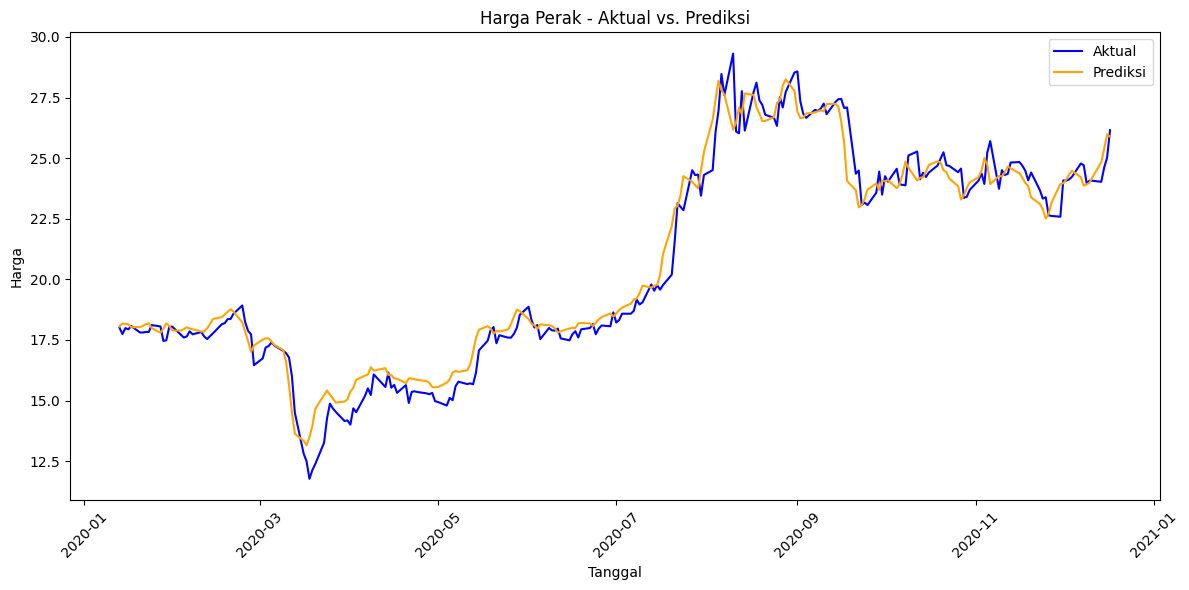

In [54]:
# Plotting
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, scaler.inverse_transform(y_test), label='Aktual', color='blue')
plt.plot(y_test.index, y_pred, label='Prediksi', color='orange')
plt.title('Harga Perak - Aktual vs. Prediksi')
plt.xlabel('Tanggal')
plt.ylabel('Harga')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [55]:
# Ambil nilai terakhir dari data uji untuk membuat prediksi hari esok
last_row = x_test.iloc[-1][['t-1', 't-2', 't-3']].values.reshape(1, -1, 1)

# Prediksi harga untuk hari esok
predicted_value_normalized = model.predict(last_row)
predicted_value = scaler.inverse_transform(predicted_value_normalized.reshape(-1, 1))

# Ambil harga terakhir yang diketahui dari data aslinya
last_price = scaler.inverse_transform(y_test.iloc[-1].values.reshape(-1, 1))

# Hitung persentase perubahan dari harga terakhir ke harga prediksi
percentage_change = ((predicted_value[0][0] - last_price[0][0]) / last_price[0][0]) * 100

# Tentukan tanda perubahan
if percentage_change > 0:
    change_sign = '+'
else:
    change_sign = ''

# Tampilkan hasil prediksi
print(f'Harga perak hari ini: {last_price[0][0]:.2f}')
#print(f'Prediksi harga perak untuk hari esok: {predicted_value[0][0]:.2f} ({change_sign}{percentage_change:.2f}%)')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Harga perak hari ini: 18.00


#menggunakan lag 4

In [56]:
#  sliding window
lags = [1, 2, 3, 4]
df_windowed4 = sliding_window_embedded(df_asli, lags)
df_windowed4.head()

,Terakhir,Pembukaan,Tertinggi,Terendah,Vol.,Perubahan%,Terakhir_Normalized,t-1,t-2,t-3,t-4
Tanggal,,,,,,,,,,,
2024-10-07,32.004,"32,450","32,595","31,655","55,63K","-1,20%",0.977769,0.909917,0.913300,0.940847,0.965349
2024-10-04,32.394,"32,290","33,225","31,755","86,41K","-0,22%",0.996617,0.977769,0.909917,0.913300,0.940847
2024-10-03,32.464,"32,100","32,485","31,650","56,40K","1,70%",1.000000,0.996617,0.977769,0.909917,0.913300
2024-10-02,31.920,"31,705","32,590","31,260","71,06K","0,56%",0.973710,1.000000,0.996617,0.977769,0.909917
2024-10-01,31.742,"31,420","32,145","31,380","61,99K","0,90%",0.965107,0.973710,1.000000,0.996617,0.977769


In [57]:
lags_columns = df_windowed4[['t-1', 't-2', 't-3', 't-4','Terakhir_Normalized']]
lags_columns.head()

,t-1,t-2,t-3,t-4,Terakhir_Normalized
Tanggal,,,,,
2024-10-07,0.909917,0.913300,0.940847,0.965349,0.977769
2024-10-04,0.977769,0.909917,0.913300,0.940847,0.996617
2024-10-03,0.996617,0.977769,0.909917,0.913300,1.000000
2024-10-02,1.000000,0.996617,0.977769,0.909917,0.973710
2024-10-01,0.973710,1.000000,0.996617,0.977769,0.965107


pelajari manual LSTm 3 input 1 output

In [58]:
# Split  data
input_df = df_windowed4[['t-1', 't-2', 't-3', 't-4']]
target_df = df_windowed4[['Terakhir_Normalized']]
train_size = 0.8

def split_data(data, target, train_size):
    split_index = int(len(data) * train_size)
    x_train = data[:split_index]
    y_train = target[:split_index]
    x_test = data[split_index:]
    y_test = target[split_index:]
    return x_train, y_train, x_test, y_test

x_train, y_train, x_test, y_test = split_data(input_df, target_df, train_size)

print(f"Jumlah data pelatihan: {len(x_train)}")
print(f"Jumlah data pengujian: {len(x_test)}")
print(f"Ukuran data pelatihan: {x_train.shape}")
print(f"Ukuran data pengujian: {x_test.shape}")

Jumlah data pelatihan: 968
Jumlah data pengujian: 243
Ukuran data pelatihan: (968, 4)
Ukuran data pengujian: (243, 4)


In [59]:
#LSTM Model
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25, activation='relu'))
model.add(Dense(1))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [60]:
import pickle

# Simpan model ke file .pkl
with open('lstm_model.pkl', 'wb') as file:
    pickle.dump(model, file)

print("Model berhasil disimpan ke lstm_model.pkl")


Model berhasil disimpan ke lstm_model.pkl


In [61]:
# 1. Ambil bobot sebelum training
print("Bobot sebelum training:")
for layer in model.layers:
    weights = layer.get_weights()  # Mendapatkan bobot dan bias
    if weights:  # Jika layer memiliki bobot
        print(f"{layer.name} - Bobot: {np.array(weights[0]).shape}, Bias: {np.array(weights[1]).shape}")


Bobot sebelum training:
lstm_4 - Bobot: (1, 200), Bias: (50, 200)
lstm_5 - Bobot: (50, 200), Bias: (50, 200)
dense_4 - Bobot: (50, 25), Bias: (25,)
dense_5 - Bobot: (25, 1), Bias: (1,)


In [62]:
# compile dan melatih model
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train.values.reshape(x_train.shape[0], x_train.shape[1], 1), y_train, batch_size=16, epochs=25)


Epoch 1/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.1698
Epoch 2/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0033
Epoch 3/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0017
Epoch 4/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 8.1764e-04
Epoch 5/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.6297e-04
Epoch 6/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 7.5235e-04
Epoch 7/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.5623e-04
Epoch 8/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 7.5437e-04
Epoch 9/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 8.0870e-04
Epoch 10/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 7.1750e-04
Epoch 11/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 7.8751e-04
Epoch 12/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 7.7257e-04
Epoch 13/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.6537e-04
Epoch 14/25
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 7.1737e-04
Epoch 15/25
61/61 ━━━━━━━━━━━━━━━━━━━

In [63]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                        │ (None, 4, 50)               │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 25)                  │           1,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 95,705 (373.85 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 63,804 (249.24 KB)

In [64]:
# 2. Ambil bobot setelah training
print("\nBobot setelah training:")
for layer in model.layers:
    weights = layer.get_weights()  # Mendapatkan bobot dan bias
    if weights:  # Jika layer memiliki bobot
        print(f"{layer.name} - Bobot: {np.array(weights[0]).shape}, Bias: {np.array(weights[1]).shape}")


Bobot setelah training:
lstm_4 - Bobot: (1, 200), Bias: (50, 200)
lstm_5 - Bobot: (50, 200), Bias: (50, 200)
dense_4 - Bobot: (50, 25), Bias: (25,)
dense_5 - Bobot: (25, 1), Bias: (1,)


In [65]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
# buat prediksi
y_pred_scaled = model.predict(x_test.values.reshape(x_test.shape[0], x_test.shape[1], 1))
y_pred = scaler.inverse_transform(y_pred_scaled)

# Hitung error
mse = mean_squared_error(scaler.inverse_transform(y_test), y_pred)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(scaler.inverse_transform(y_test), y_pred) * 100

# Tampilkan  error
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f} %')



8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step
Mean Squared Error (MSE): 0.6510712387814276
Root Mean Squared Error (RMSE): 0.8068898554210653
Mean Absolute Percentage Error (MAPE): 3.20 %


In [66]:
# Ambil nilai terakhir dari data uji untuk membuat prediksi hari esok
last_row = x_test.iloc[-1][['t-1', 't-2', 't-3', 't-4']].values.reshape(1, -1, 1)

# Prediksi harga untuk hari esok
predicted_value_normalized = model.predict(last_row)
predicted_value = scaler.inverse_transform(predicted_value_normalized.reshape(-1, 1))

# Ambil harga terakhir yang diketahui dari data aslinya
last_price = scaler.inverse_transform(y_test.iloc[-1].values.reshape(-1, 1))

# Hitung persentase perubahan dari harga terakhir ke harga prediksi
percentage_change = ((predicted_value[0][0] - last_price[0][0]) / last_price[0][0]) * 100

# Tentukan tanda perubahan
if percentage_change > 0:
    change_sign = '+'
else:
    change_sign = ''

# Tampilkan hasil prediksi
print(f'Harga perak hari ini: {last_price[0][0]:.2f}')
#print(f'Prediksi harga perak untuk hari esok: {predicted_value[0][0]:.2f} ({change_sign}{percentage_change:.2f}%)')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Harga perak hari ini: 18.00


#LSTM dengan ensemble bagging

In [67]:
# Fungsi untuk membuat dan melatih model LSTM
def create_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dense(25, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Ensemble LSTM menggunakan Bagging
def bagging_lstm_ensemble(x_train, y_train, x_test, n_estimators=5, epochs=10, batch_size=16):
    predictions = []

    for i in range(n_estimators):
        print(f"Training model {i+1}/{n_estimators}")

        # Membuat model LSTM baru
        model = create_lstm_model(input_shape=(x_train.shape[1], 1))

        # Melatih model
        model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)

        # Prediksi dengan model yang sudah dilatih
        y_pred = model.predict(x_test)

        # Simpan hasil prediksi
        predictions.append(y_pred)

    # Menggabungkan hasil prediksi dengan rata-rata
    ensemble_pred = np.mean(predictions, axis=0)

    return ensemble_pred

Training model 1/5
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.1530
Epoch 2/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0026
Epoch 3/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0010
Epoch 4/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.6052e-04
Epoch 5/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 7.6332e-04
Epoch 6/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 8.7886e-04
Epoch 7/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 7.7331e-04
Epoch 8/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.3421e-04
Epoch 9/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 8.9985e-04
Epoch 10/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.4228e-04
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step
Training model 2/5
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


61/61 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 0.1479
Epoch 2/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0034
Epoch 3/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0016
Epoch 4/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 8.5309e-04
Epoch 5/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 7.4451e-04
Epoch 6/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 7.8884e-04
Epoch 7/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.9126e-04
Epoch 8/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.3023e-04
Epoch 9/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.5469e-04
Epoch 10/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 7.7933e-04
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step
Training model 3/5
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.2913
Epoch 2/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0045
Epoch 3/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0021
Epoch 4/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0012
Epoch 5/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 7.3634e-04
Epoch 6/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6.7094e-04
Epoch 7/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 7.1805e-04
Epoch 8/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 6.9919e-04
Epoch 9/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.7187e-04
Epoch 10/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.6734e-04


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step
Training model 4/5
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.1746
Epoch 2/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0030
Epoch 3/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0014
Epoch 4/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 7.2981e-04
Epoch 5/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 7.2270e-04
Epoch 6/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 6.6970e-04
Epoch 7/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 6.5604e-04
Epoch 8/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 7.7861e-04
Epoch 9/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 7.1810e-04
Epoch 10/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.6297e-04


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step
Training model 5/5
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.2086
Epoch 2/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0045
Epoch 3/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0019
Epoch 4/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 9.4195e-04
Epoch 5/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 7.2355e-04
Epoch 6/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 6.4730e-04
Epoch 7/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 7.5508e-04
Epoch 8/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 7.4213e-04
Epoch 9/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 7.2995e-04
Epoch 10/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 7.3612e-04
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step


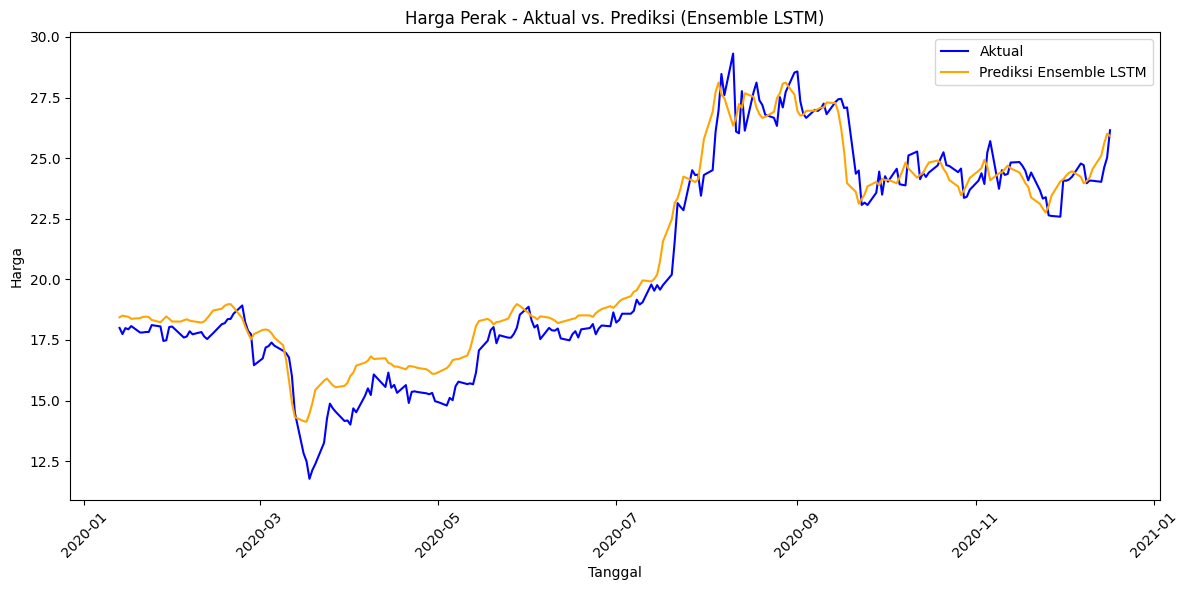

Mean Squared Error: 0.9336977549377895
Root Mean Squared Error: 0.966280370771232
Mean Absolute Percentage Error (MAPE): 4.19 %


In [68]:
# Reshape data untuk input LSTM
x_train_reshaped = x_train.values.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test_reshaped = x_test.values.reshape((x_test.shape[0], x_test.shape[1], 1))

# Latih dan prediksi menggunakan ensemble LSTM
ensemble_predictions_scaled = bagging_lstm_ensemble(x_train_reshaped, y_train, x_test_reshaped, n_estimators=5, epochs=10)

# Mengembalikan hasil prediksi ke skala asli
y_test_unscaled = scaler.inverse_transform(y_test)
ensemble_predictions_unscaled = scaler.inverse_transform(ensemble_predictions_scaled)

# Menghitung metrik error
mse = mean_squared_error(y_test_unscaled, ensemble_predictions_unscaled)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_test_unscaled - ensemble_predictions_unscaled) / y_test_unscaled)) * 100

# Plot hasil prediksi
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test_unscaled, label='Aktual', color='blue')
plt.plot(y_test.index, ensemble_predictions_unscaled, label='Prediksi Ensemble LSTM', color='orange')
plt.title('Harga Perak - Aktual vs. Prediksi (Ensemble LSTM)')
plt.xlabel('Tanggal')
plt.ylabel('Harga')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Menampilkan metrik error
print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f} %')


In [69]:

# Ambil nilai terakhir dari data uji untuk membuat prediksi hari esok
last_row = x_test.iloc[-1][['t-1', 't-2', 't-3']].values.reshape(1, -1, 1)

# Prediksi harga untuk hari esok menggunakan model terakhir dari ensemble
predicted_value_normalized = np.mean([model.predict(last_row) for model in [create_lstm_model(input_shape=(x_train.shape[1], 1)) for _ in range(5)]], axis=0)

# Mengembalikan prediksi ke skala asli
predicted_value = scaler.inverse_transform(predicted_value_normalized.reshape(-1, 1))

# Ambil harga terakhir yang diketahui dari data aslinya
last_price = scaler.inverse_transform(y_test.iloc[-1].values.reshape(-1, 1))

# Hitung persentase perubahan dari harga terakhir ke harga prediksi
percentage_change = ((predicted_value[0][0] - last_price[0][0]) / last_price[0][0]) * 100

# Tentukan tanda perubahan
change_sign = '+' if percentage_change > 0 else ''

# Tampilkan hasil prediksi
print(f'Harga perak hari ini: {last_price[0][0]:.2f}')
#print(f'Prediksi harga perak untuk hari esok: {predicted_value[0][0]:.2f} ({change_sign}{percentage_change:.2f}%)')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step
Harga perak hari ini: 18.00


In [71]:
# *** Bagian untuk memprediksi harga esok hari ***
# Input harga perak hari ini dan harga dari dua hari sebelumnya
sell_1 = float(input("Masukkan harga perak hari ini: "))  # Harga saat ini
sell_2 = float(input("Masukkan harga perak 1 hari yang lalu: "))  # Harga 1 hari yang lalu
sell_3 = float(input("Masukkan harga perak 2 hari yang lalu: "))  # Harga 2 hari yang lalu

# Siapkan data untuk prediksi
last_row = np.array([
    scaler.transform([[sell_1]]).flatten()[0],
    scaler.transform([[sell_2]]).flatten()[0],
    scaler.transform([[sell_3]]).flatten()[0]
]).reshape(1, -1)

# Prediksi harga esok hari menggunakan model ensemble
predicted_value_normalized = np.mean([model.predict(last_row) for model in [create_lstm_model(input_shape=(x_train.shape[1], 1)) for _ in range(5)]], axis=0)

# Invers transformasi untuk mendapatkan nilai prediksi dalam skala asli
predicted_value = scaler.inverse_transform(predicted_value_normalized.reshape(-1, 1))

# Ambil harga terakhir yang diketahui
last_price = sell_1

# Hitung persentase perubahan
percentage_change = ((predicted_value[0][0] - last_price) / last_price) * 100
change_sign = '+' if percentage_change > 0 else ''

# Format dan tampilkan hasil
formatted_predicted_value = f"{predicted_value[0][0]:,.2f}".replace(',', 'X').replace('.', ',').replace('X', '.')
formatted_last_price = f"{last_price:,.2f}".replace(',', 'X').replace('.', ',').replace('X', '.')

print(f'Harga perak saat ini: Rp {formatted_last_price}')
#print(f'Prediksi harga perak untuk esok hari: Rp {formatted_predicted_value} ({change_sign}{percentage_change:.2f}%)')


Masukkan harga perak hari ini: 0.99
Masukkan harga perak 1 hari yang lalu: 0.90
Masukkan harga perak 2 hari yang lalu: 0.95


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step
Harga perak saat ini: Rp 0,99


In [72]:
pip install gradio


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 MB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.1/320.1 kB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 79.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 8.7 MB/s eta 0:00:00
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 3.0.2
    Uninstalling MarkupSafe-3.0.2:
      Successfully uninstalled MarkupSafe-3.0.2


In [73]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [74]:
import gradio as gr
import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler

# Fungsi untuk memuat model dan scaler
def load_resources():
    # Load model dan scaler (sesuaikan dengan path file model dan scaler)
    model = load_model('/content/drive/MyDrive/Colab Notebooks/project/model/lstm_model.h5')
    scaler = MinMaxScaler(feature_range=(0, 1))
    return model, scaler

# Fungsi untuk memprediksi harga perak berdasarkan input
def predict_price(input_data):
    try:
        # Memastikan input berupa angka (misalnya dalam bentuk string yang dipisahkan koma)
        input_data = [float(i) for i in input_data.split(',')]  # Memisahkan input berdasarkan koma
        input_data = np.array(input_data).reshape(-1, 1)

        # Memuat model dan scaler
        model, scaler = load_resources()

        # Melakukan normalisasi terhadap data input
        scaled_input = scaler.fit_transform(input_data)

        # Membuat prediksi menggunakan model LSTM
        predicted_price = model.predict(scaled_input)

        # Mengembalikan harga yang diprediksi
        predicted_price = scaler.inverse_transform(predicted_price)
        return f"Harga perak yang diprediksi: {predicted_price[0][0]:.2f} "
    except Exception as e:
        return f"Terjadi kesalahan: {e}"

# Membuat antarmuka Gradio
interface = gr.Interface(
    fn=predict_price,
    inputs=gr.Textbox(label="Masukkan Data Harga Perak (time series) - pisahkan dengan koma"),
    outputs=gr.Textbox(label="Prediksi Harga Perak"),
    live=True,
    title="Prediksi Harga Perak Menggunakan LSTM"
)

# Menjalankan antarmuka
interface.launch()


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://28394e3ae502f2f832.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
